In [3]:
pip install pandas numpy matplotlib seaborn scikit-learn plotly faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.6 MB/s eta 0:00:00


Sample data generated and saved to 'financial_data.csv'
         Date        Category  Amount
0  2023-01-01         Housing   98.19
1  2023-01-01  Transportation   16.08
2  2023-01-01        Shopping   60.20
3  2023-01-01         Housing  177.58
4  2023-01-02      Dining Out   90.81
Total entries: 2000


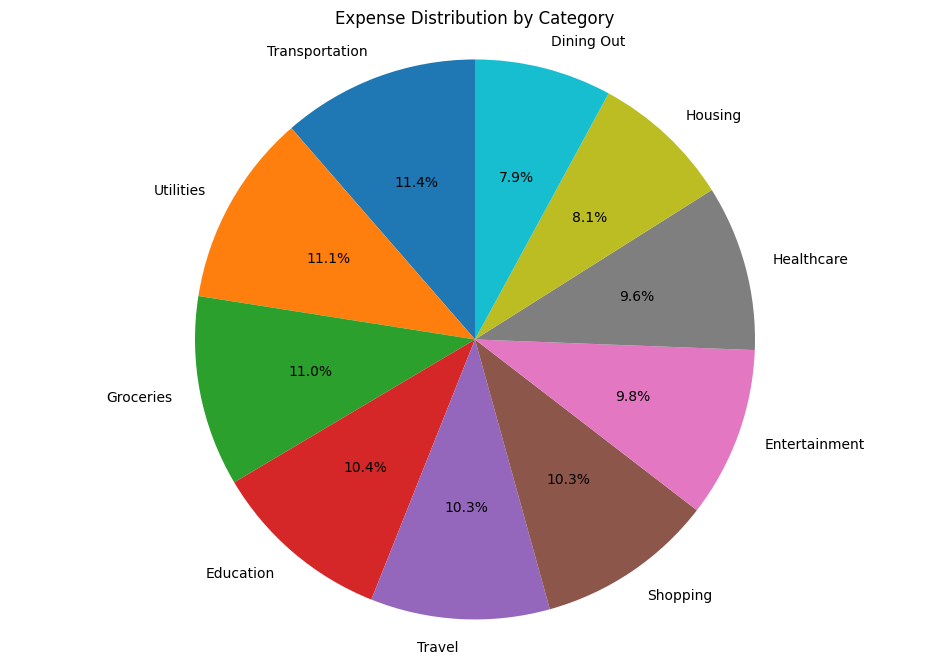

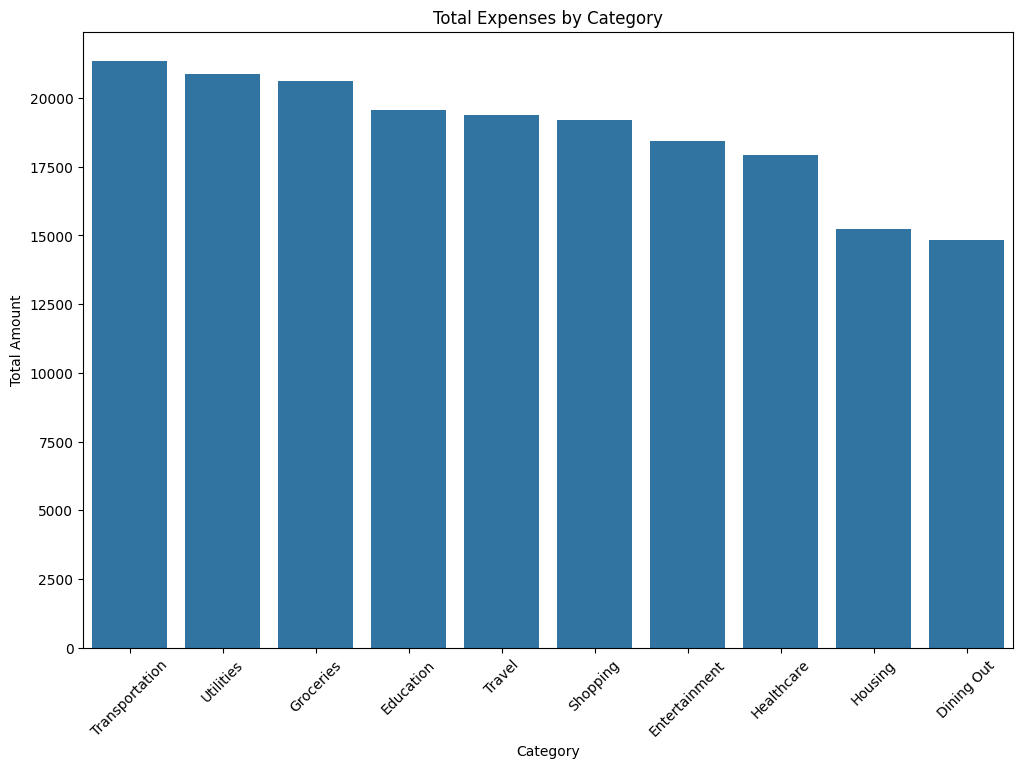

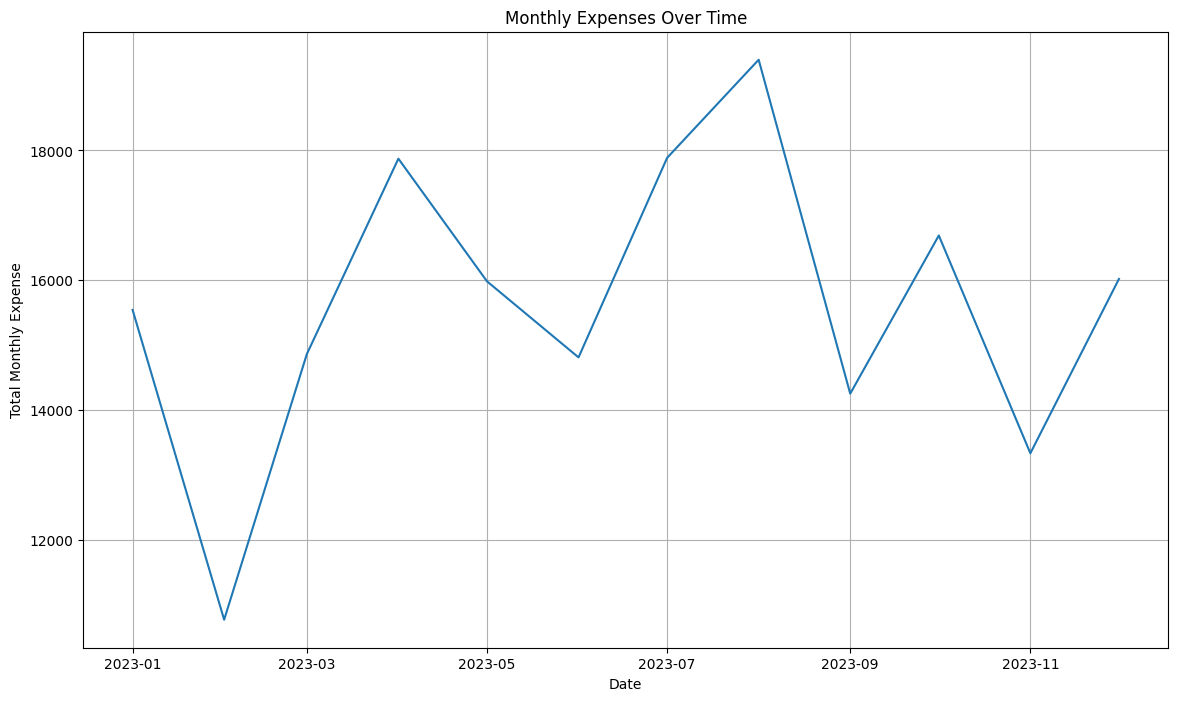

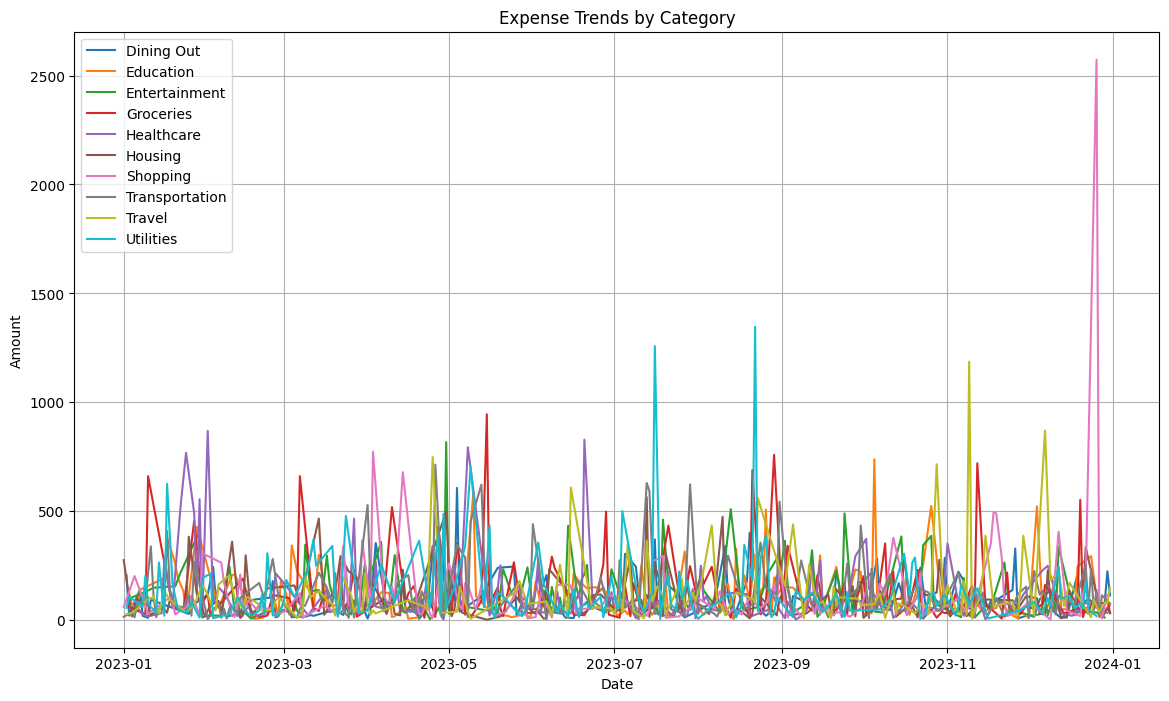

Model Performance:
Mean Squared Error: 30027.86
Mean Absolute Error: 82.99
R-squared Score: -0.13


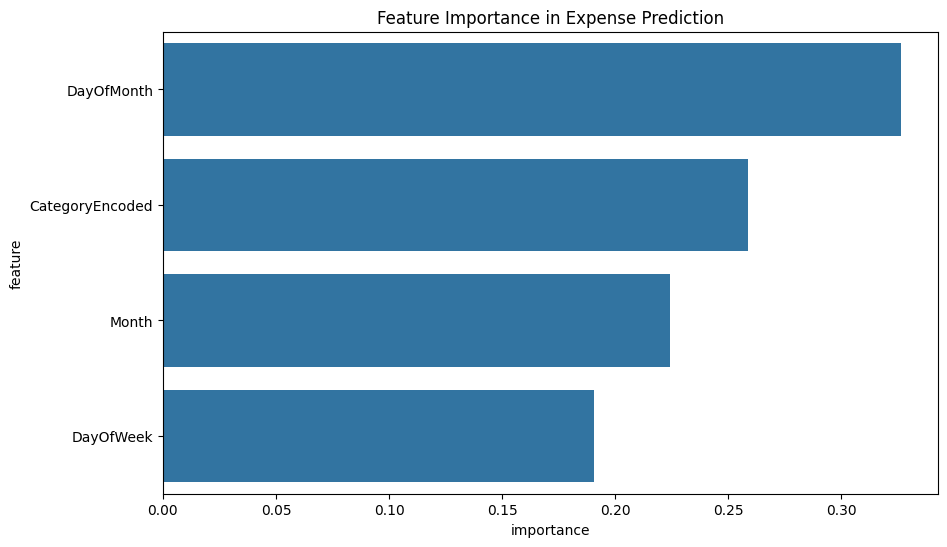

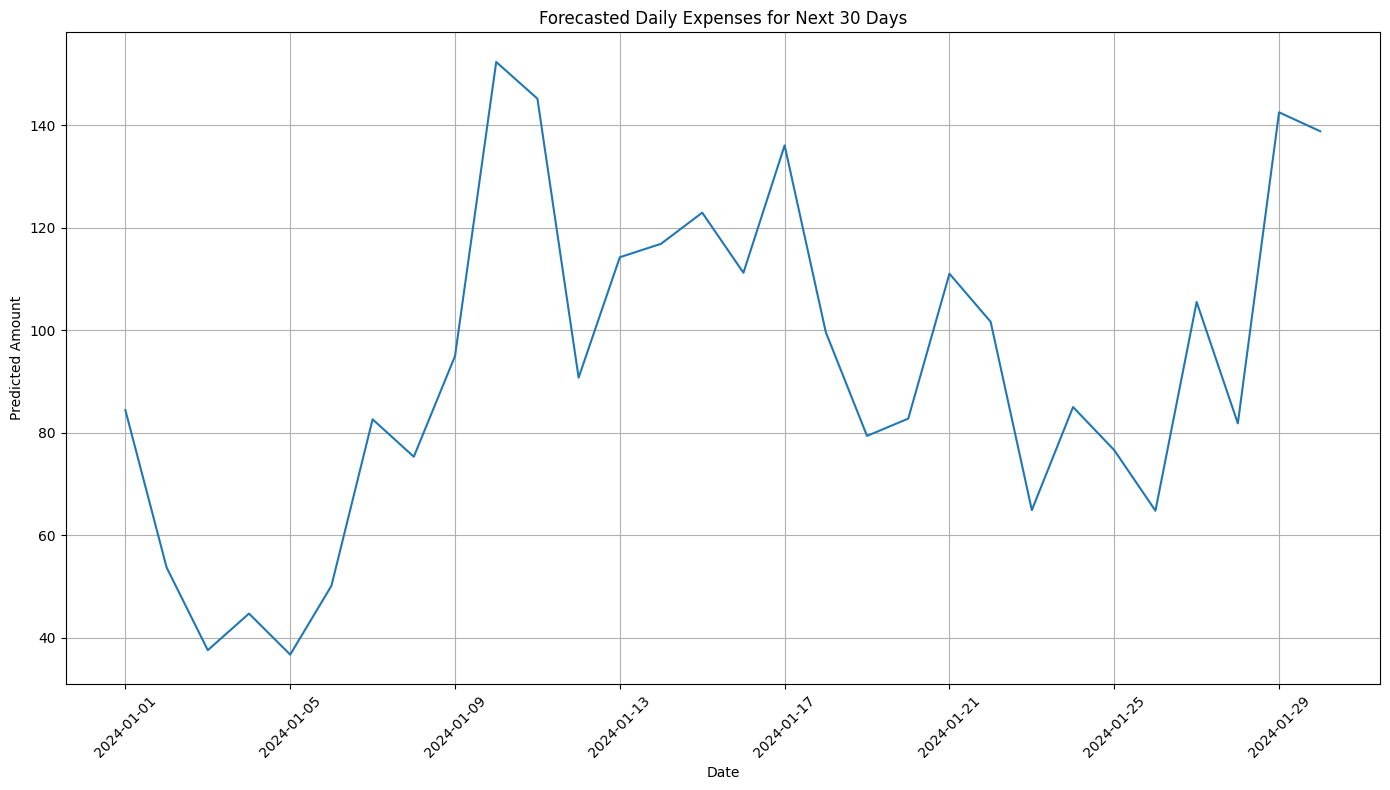

Spending Habits Analysis:
1. Your highest spending day is typically 1 (average: $108.77)
2. Your lowest spending day is typically 4 (average: $85.41)
3. Your highest spending month is typically 8 (total: $19397.37)
4. Your lowest spending month is typically 2 (total: $10774.55)

Savings Strategies:
1. Your total expenses are $187447.51
2. Your top expense category is Transportation, accounting for 11.4% of your total expenses
3. Consider reducing spending in Transportation to increase savings
4. Set a budget for each category and try to stick to it
5. Look for areas where you can cut back, especially in discretionary spending categories
6. Consider automating your savings by setting up automatic transfers to a savings account
7. Review your subscriptions and cancel any that you don't use frequently
8. Plan your meals and grocery shopping to reduce food waste and dining out expenses
9. Use energy-saving techniques to reduce utility costs
10. Consider using cashback credit cards or apps 

In [4]:
# Cell 1: Imports and Data Generation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.graph_objects as go
import plotly.express as px
from faker import Faker
import random

def generate_sample_data(num_entries=2000):
    fake = Faker()
    Faker.seed(42)
    np.random.seed(42)

    start_date = datetime(2023, 1, 1)
    end_date = start_date + timedelta(days=365)
    categories = ['Groceries', 'Utilities', 'Entertainment', 'Transportation', 'Dining Out', 'Shopping', 'Healthcare', 'Education', 'Housing', 'Travel']

    data = []
    for _ in range(num_entries):
        date = fake.date_between(start_date=start_date, end_date=end_date)
        category = random.choice(categories)
        amount = round(np.random.lognormal(mean=4, sigma=1), 2)
        data.append([date, category, amount])

    df = pd.DataFrame(data, columns=['Date', 'Category', 'Amount'])
    df = df.sort_values('Date').reset_index(drop=True)
    df.to_csv('financial_data.csv', index=False)
    return df

# Generate and save sample data
sample_data = generate_sample_data(2000)
print("Sample data generated and saved to 'financial_data.csv'")
print(sample_data.head())
print(f"Total entries: {len(sample_data)}")

# Cell 2: PersonalFinanceAnalyzer Class Definition

class PersonalFinanceAnalyzer:
    def __init__(self, data_file):
        self.data = pd.read_csv(data_file)
        self.prepare_data()
        self.model = None

    def prepare_data(self):
        self.data['Date'] = pd.to_datetime(self.data['Date'])
        le = LabelEncoder()
        self.data['CategoryEncoded'] = le.fit_transform(self.data['Category'])
        self.category_mapping = dict(zip(le.transform(le.classes_), le.classes_))
        self.data['Month'] = self.data['Date'].dt.month
        self.data['Year'] = self.data['Date'].dt.year
        self.data['DayOfWeek'] = self.data['Date'].dt.dayofweek
        self.data['DayOfMonth'] = self.data['Date'].dt.day

    def categorize_expenses(self):
        return self.data.groupby('Category')['Amount'].sum().sort_values(ascending=False)

    def monthly_expense_trend(self):
        monthly_data = self.data.groupby(['Year', 'Month'])['Amount'].sum().reset_index()
        monthly_data['Date'] = pd.to_datetime(monthly_data[['Year', 'Month']].assign(DAY=1))
        return monthly_data

    def category_expense_trend(self):
        return self.data.groupby(['Category', 'Date'])['Amount'].sum().reset_index()

    def visualize_spending_patterns(self):
        category_expenses = self.categorize_expenses()

        # Pie chart
        plt.figure(figsize=(12, 8))
        plt.pie(category_expenses, labels=category_expenses.index, autopct='%1.1f%%', startangle=90)
        plt.title('Expense Distribution by Category')
        plt.axis('equal')
        plt.show()

        # Bar chart
        plt.figure(figsize=(12, 8))
        sns.barplot(x=category_expenses.index, y=category_expenses.values)
        plt.title('Total Expenses by Category')
        plt.xlabel('Category')
        plt.ylabel('Total Amount')
        plt.xticks(rotation=45)
        plt.show()

        # Time series plot
        monthly_trend = self.monthly_expense_trend()
        plt.figure(figsize=(14, 8))
        plt.plot(monthly_trend['Date'], monthly_trend['Amount'])
        plt.title('Monthly Expenses Over Time')
        plt.xlabel('Date')
        plt.ylabel('Total Monthly Expense')
        plt.grid(True)
        plt.show()

    def visualize_category_trends(self):
        category_trend = self.category_expense_trend()
        plt.figure(figsize=(14, 8))
        for category in category_trend['Category'].unique():
            cat_data = category_trend[category_trend['Category'] == category]
            plt.plot(cat_data['Date'], cat_data['Amount'], label=category)
        plt.title('Expense Trends by Category')
        plt.xlabel('Date')
        plt.ylabel('Amount')
        plt.legend()
        plt.grid(True)
        plt.show()

    def interactive_spending_sunburst(self):
        hierarchical_data = self.data.groupby(['Year', 'Month', 'Category'])['Amount'].sum().reset_index()
        fig = px.sunburst(hierarchical_data, path=['Year', 'Month', 'Category'], values='Amount')
        fig.update_layout(title='Interactive Spending Hierarchy')
        fig.show()

    def train_predictive_model(self):
        X = self.data[['CategoryEncoded', 'Month', 'DayOfMonth', 'DayOfWeek']]
        y = self.data['Amount']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.model.fit(X_train, y_train)

        y_pred = self.model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = self.model.score(X_test, y_test)

        print(f"Model Performance:")
        print(f"Mean Squared Error: {mse:.2f}")
        print(f"Mean Absolute Error: {mae:.2f}")
        print(f"R-squared Score: {r2:.2f}")

        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance)
        plt.title('Feature Importance in Expense Prediction')
        plt.show()

    def forecast_expenses(self, days=30):
        if self.model is None:
            print("Please train the model first using train_predictive_model()")
            return

        last_date = self.data['Date'].max()
        future_dates = [last_date + timedelta(days=i) for i in range(1, days+1)]
        future_df = pd.DataFrame({'Date': future_dates})
        future_df['CategoryEncoded'] = self.data['CategoryEncoded'].mode().iloc[0]
        future_df['Month'] = future_df['Date'].dt.month
        future_df['DayOfMonth'] = future_df['Date'].dt.day
        future_df['DayOfWeek'] = future_df['Date'].dt.dayofweek

        X_future = future_df[['CategoryEncoded', 'Month', 'DayOfMonth', 'DayOfWeek']]
        forecasted_expenses = self.model.predict(X_future)

        plt.figure(figsize=(14, 8))
        plt.plot(future_dates, forecasted_expenses)
        plt.title(f'Forecasted Daily Expenses for Next {days} Days')
        plt.xlabel('Date')
        plt.ylabel('Predicted Amount')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        return pd.DataFrame({'Date': future_dates, 'Forecasted_Amount': forecasted_expenses})

    def analyze_spending_habits(self):
        weekday_spending = self.data.groupby('DayOfWeek')['Amount'].mean().sort_values(ascending=False)
        high_spending_day = weekday_spending.index[0]
        low_spending_day = weekday_spending.index[-1]

        print("Spending Habits Analysis:")
        print(f"1. Your highest spending day is typically {high_spending_day} (average: ${weekday_spending[high_spending_day]:.2f})")
        print(f"2. Your lowest spending day is typically {low_spending_day} (average: ${weekday_spending[low_spending_day]:.2f})")

        monthly_spending = self.data.groupby('Month')['Amount'].sum()
        high_spending_month = monthly_spending.idxmax()
        low_spending_month = monthly_spending.idxmin()

        print(f"3. Your highest spending month is typically {high_spending_month} (total: ${monthly_spending[high_spending_month]:.2f})")
        print(f"4. Your lowest spending month is typically {low_spending_month} (total: ${monthly_spending[low_spending_month]:.2f})")

    def suggest_savings_strategies(self):
        category_expenses = self.data.groupby('Category')['Amount'].sum().sort_values(ascending=False)
        total_expenses = category_expenses.sum()

        print("\nSavings Strategies:")
        print(f"1. Your total expenses are ${total_expenses:.2f}")
        print(f"2. Your top expense category is {category_expenses.index[0]}, accounting for {(category_expenses.iloc[0]/total_expenses)*100:.1f}% of your total expenses")
        print(f"3. Consider reducing spending in {category_expenses.index[0]} to increase savings")
        print("4. Set a budget for each category and try to stick to it")
        print("5. Look for areas where you can cut back, especially in discretionary spending categories")
        print("6. Consider automating your savings by setting up automatic transfers to a savings account")
        print("7. Review your subscriptions and cancel any that you don't use frequently")
        print("8. Plan your meals and grocery shopping to reduce food waste and dining out expenses")
        print("9. Use energy-saving techniques to reduce utility costs")
        print("10. Consider using cashback credit cards or apps for regular purchases to earn rewards")

    def generate_financial_report(self):
        report = "Personal Finance Analysis Report\n"
        report += "================================\n\n"

        total_expenses = self.data['Amount'].sum()
        avg_daily_expense = self.data.groupby('Date')['Amount'].sum().mean()
        report += f"Total Expenses: ${total_expenses:.2f}\n"
        report += f"Average Daily Expense: ${avg_daily_expense:.2f}\n\n"

        category_expenses = self.data.groupby('Category')['Amount'].sum().sort_values(ascending=False)
        report += "Top 3 Expense Categories:\n"
        for i, (category, amount) in enumerate(category_expenses.head(3).items(), 1):
            report += f"{i}. {category}: ${amount:.2f} ({amount/total_expenses*100:.1f}%)\n"

        report += "\nMonthly Expense Trend:\n"
        monthly_trend = self.data.groupby(['Year', 'Month'])['Amount'].sum().reset_index()
        monthly_trend['Date'] = pd.to_datetime(monthly_trend[['Year', 'Month']].assign(DAY=1))
        for _, row in monthly_trend.iterrows():
            report += f"{row['Date'].strftime('%B %Y')}: ${row['Amount']:.2f}\n"

        return report

# Cell 3: Usage Example

# Create an instance of the PersonalFinanceAnalyzer
analyzer = PersonalFinanceAnalyzer('financial_data.csv')

# Generate and display visualizations
analyzer.visualize_spending_patterns()
analyzer.visualize_category_trends()
analyzer.interactive_spending_sunburst()

# Train the predictive model and show feature importance
analyzer.train_predictive_model()

# Forecast expenses for the next 30 days
forecast = analyzer.forecast_expenses(days=30)

# Analyze spending habits and suggest savings strategies
analyzer.analyze_spending_habits()
analyzer.suggest_savings_strategies()

# Generate and print the financial report
report = analyzer.generate_financial_report()
print(report)